In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salamander

In [2]:
counts_sbs = pd.read_csv("data/pcawg_breast_sbs.csv", index_col=0)

# NMF with KL-divergence loss

In [3]:
n_signatures = 6

# NMF with Poisson noise
model = salamander.KLNMF(
    n_signatures=n_signatures,
    max_iterations=5000
)
model.fit(counts_sbs)

The fitted signatures and exposures of an NMF model can be accessed via $\texttt{model.signatures}$ and $\texttt{model.exposures}$ respecively:

In [4]:
model.signatures.head()

,Sig1,Sig2,Sig3,Sig4,Sig5,Sig6
A[C>A]A,0.000558,0.042001,0.002733,0.001515,0.017544,0.011871
A[C>A]C,0.000721,0.030924,0.000963,0.001621,0.011087,0.012307
A[C>A]G,0.000153,0.003165,0.000151,0.000019,0.002161,0.003004
A[C>A]T,0.000329,0.031758,0.001438,0.002422,0.005636,0.012699
C[C>A]A,0.001055,0.039412,0.002215,0.002002,0.009988,0.007789


In [5]:
model.exposures.head()

,SP10084,SP10150,SP10470,SP10563,SP10635,SP10944,SP11045,SP11171,SP11235,SP116331,...,SP8987,SP9251,SP9433,SP9481,SP96147,SP96163,SP96511,SP9816,SP9930,SP9979
Sig1,368.742014,2408.788660,3.564742e+02,1668.916256,86.933313,3966.741600,1547.030683,153.435000,189.573610,115.779669,...,831.210096,282.419525,5.045116e+03,2.583265,98.741441,1007.702291,809.986954,4.144899e+02,3.745192e+03,72.111735
Sig2,4103.168071,214.984124,3.620532e+03,272.612555,150.759788,1185.923847,250.467227,2024.068318,1074.942902,1706.303443,...,2728.748770,1055.802620,1.192093e-07,224.935169,573.530218,1665.726067,3655.561480,1.897084e+03,2.398579e+03,109.769999
Sig3,276.500009,2524.535984,7.186578e+02,298.032331,26.726934,2363.477201,1064.288452,122.312165,209.211300,171.861236,...,1132.286597,321.675963,6.647797e+03,31.952973,81.820362,1643.503898,1480.020458,6.611478e+02,4.780381e+03,31.668967
Sig4,70.486392,52.602996,2.040103e+02,24.290745,11.794148,68.300843,11.057570,55.009936,52.031885,110.282816,...,179.178681,1.491675,3.581918e+01,17.114614,21.187611,154.236640,297.837776,1.192093e-07,2.456081e+02,14.490304
Sig5,1763.992933,2064.002912,1.192093e-07,2104.837521,1274.208990,3460.418941,729.392772,538.328354,1723.928265,2374.468784,...,595.106177,761.716221,1.526116e+03,1279.110522,1819.011887,286.164668,276.447576,3.973429e+02,1.192093e-07,1061.741139


All implemented NMF models also come with methods to visualize the signatures, the exposures, and the signature or sample correlations:

array([<Axes: title={'center': 'Sig1'}>, <Axes: title={'center': 'Sig2'}>,
       <Axes: title={'center': 'Sig3'}>, <Axes: title={'center': 'Sig4'}>,
       <Axes: title={'center': 'Sig5'}>, <Axes: title={'center': 'Sig6'}>],
      dtype=object)

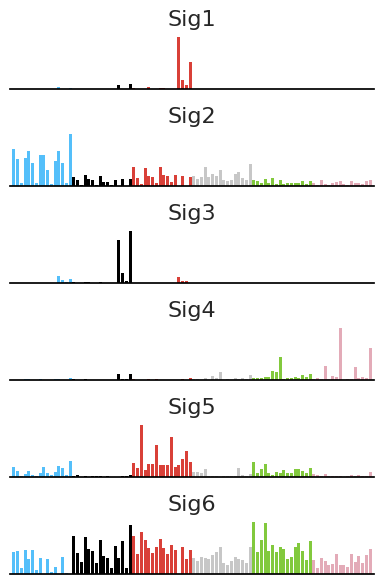

In [6]:
model.plot_signatures()

Like all other plotting methods, $\texttt{plot\_signatures()}$ just wraps around matplotlib and returns the matplotlib axes instances. This makes it effortless to apply custom modifications to a plot. For example, it is possible to rearrange the signature plots to our liking, widen all bars, and change the fontsize:

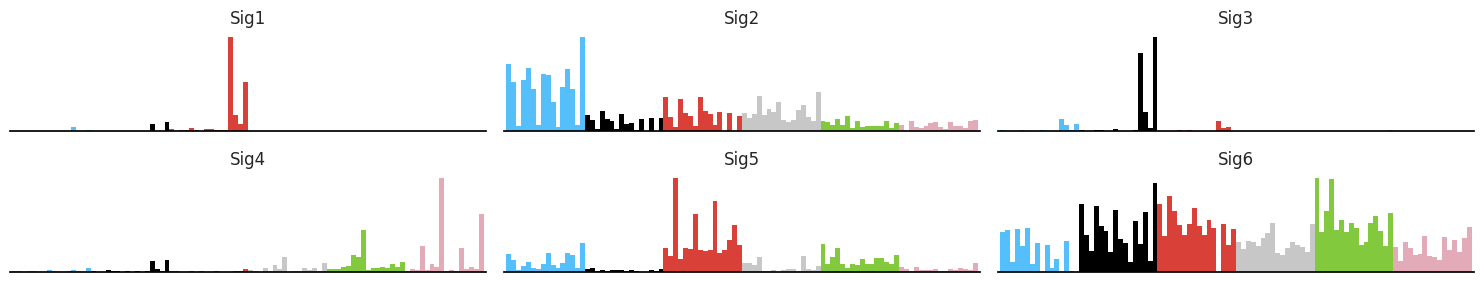

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 3))
axes = model.plot_signatures(axes=axes.flatten(), width=1)

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=12)

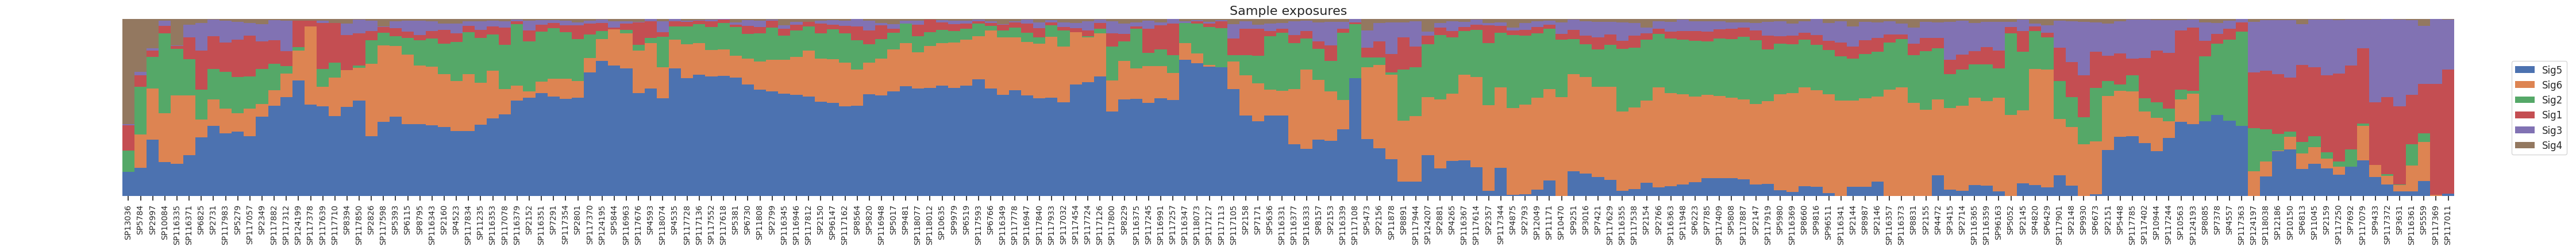

In [8]:
# stacked barplot of the exposures
_ = model.plot_exposures()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

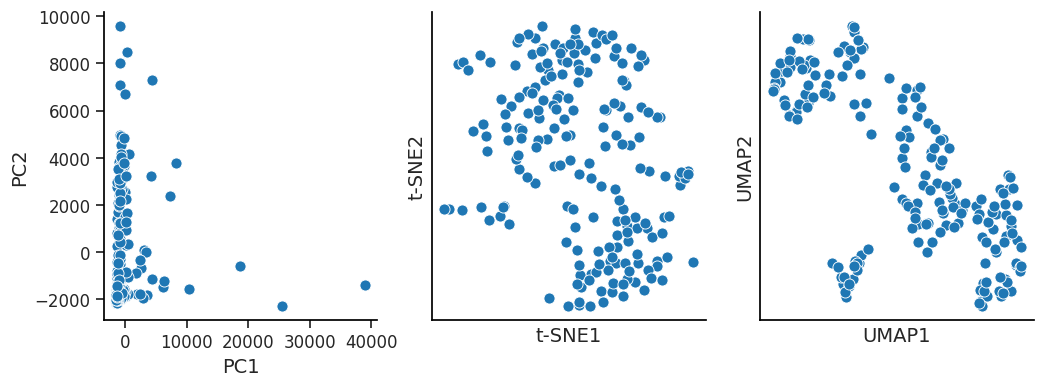

In [9]:
# PCA, t-SNE or UMAP of the sample exposures
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

model.plot_embeddings(method="pca", ax=axes[0])
model.plot_embeddings(method="tsne", ax=axes[1])
model.plot_embeddings(method="umap", ax=axes[2])

Let's say we want to color all samples with a high relative exposure to a certain signature. Again, the UMAP, t-SNE and PCA implementations just wrap around seaborns scatterplot and customizations can be made.

In [10]:
special_signature = "Sig1"
threshold = 0.4

relative_exposures = model.exposures / model.exposures.sum(axis=0)
relative_exposures = relative_exposures.T # signatures as columns
special_samples = relative_exposures.loc[relative_exposures[special_signature] >= threshold].index.to_numpy()

group_labels = [
    "special group" if sample in special_samples else "other"
    for sample in model.sample_names
]

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

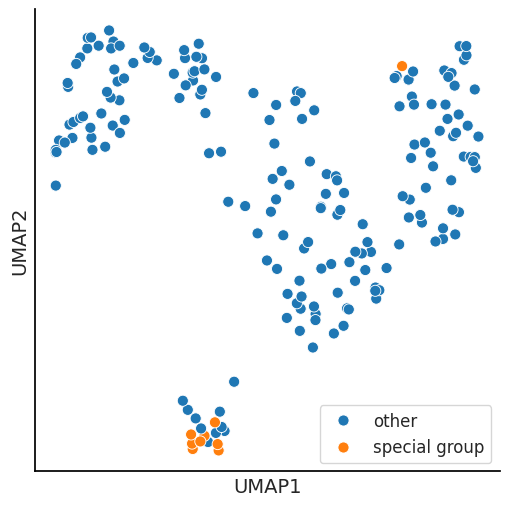

In [11]:
# colored UMAP
model.plot_embeddings(method="umap", hue=group_labels)

It is also possible to annotate the projected exposures. By default, Salamander adjusts the annotations to prevent them from overlapping:

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

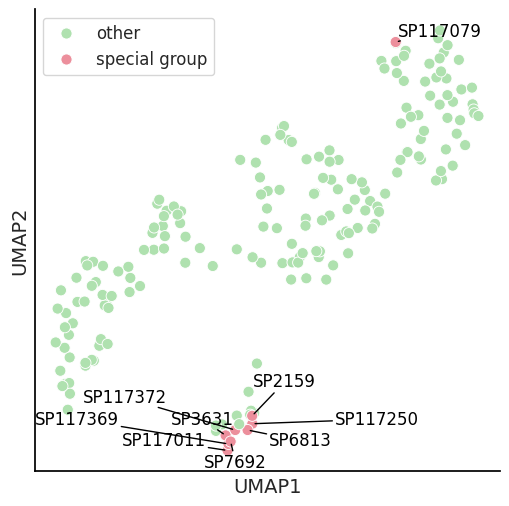

In [12]:
annotations = [name if name in special_samples else "" for name in model.sample_names]

# let's also change the colors
palette = ["#afe1af", "#ec8f9c"]

model.plot_embeddings(
    method="umap",
    hue=group_labels,
    palette=palette,
    annotations=annotations,
    adjust_kwargs={"arrowprops": dict(arrowstyle="-", color='k')} # add lines connecting the annotations and data points
)

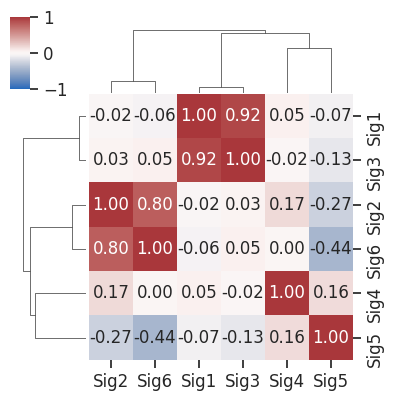

In [13]:
# signature correlations
# Pearson correlation of the exposures
model.plot_correlation(annot=True, figsize=(4,4))

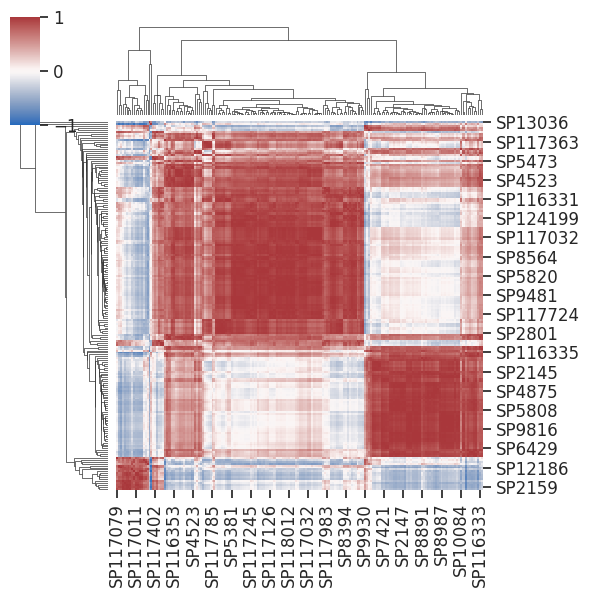

In [14]:
# sample correlations
model.plot_correlation(data="samples")

## Fixing a priori known signatures

Salamander supports fixing arbitrary many a priori known signatures during inference. However, only learning a subset of the signatures might cause NMF algorithms to get stuck in poor local optima. We recommend to track the objective function values and to compare them to runs where no signatures were fixed.

In [15]:
catalog = pd.read_csv("data/COSMIC_v3.3.1_SBS_GRCh38.csv", index_col=0)
my_known_signatures = catalog[["SBS3", "SBS13"]]

array([<Axes: title={'center': 'SBS3'}>,
       <Axes: title={'center': 'SBS13'}>,
       <Axes: title={'center': 'Sig1'}>, <Axes: title={'center': 'Sig2'}>,
       <Axes: title={'center': 'Sig3'}>], dtype=object)

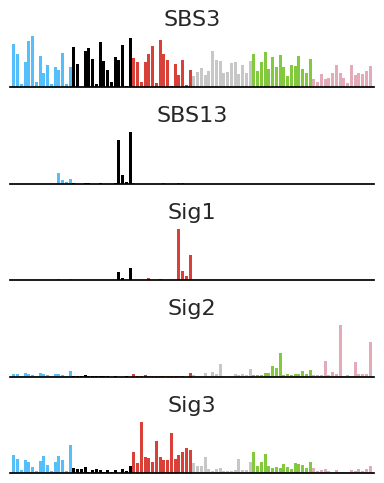

In [16]:
model = salamander.KLNMF(n_signatures=5, max_iterations=5000)
model.fit(counts_sbs, given_signatures=my_known_signatures)
model.plot_signatures()

# Other NMF models

The syntax for minimum volume NMF and correlated NMF is identical, and fixing a priori known signatures is also supported for these NMF models. In this tutorial, we only run these algorithms for 10 iterations because of their longer runtime.

**Note**: The first iteration of an algorithm takes a while because the update rules for the parameters are just-in-time compiled with [numba](https://numba.pydata.org/). All subsequent iterations are much faster.

In [17]:
# lam: volume penalty hyperparameter in the loss function of mvNMF
model_mvnmf = salamander.MvNMF(
    n_signatures=n_signatures,
    lam=1,
    max_iterations=10
)
model_mvnmf.fit(counts_sbs)

In [18]:
# dim_embeddings: common embedding dimension of the signatures and samples
model_corrnmf = salamander.CorrNMFDet(
    n_signatures=n_signatures,
    dim_embeddings=n_signatures,
    max_iterations=10
)
model_corrnmf.fit(counts_sbs)

The only difference to the above visualizations with these models is that the embedding plot of CorrNMF shows the signature embeddings as well. When coloring or annotating the projected embeddings, please note that the the first $\texttt{n\_signtures}$ many data points are the embeddings of the signatures:

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

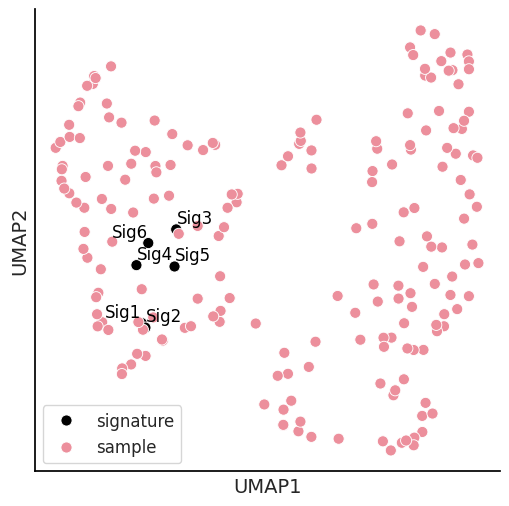

In [19]:
hue = model_corrnmf.n_signatures * ["signature"] + model_corrnmf.n_samples * ["sample"]
palette = [(0, 0, 0), "#ec8f9c"]

model_corrnmf.plot_embeddings(hue=hue, palette=palette)

# Multimodal correlated NMF

Multimodal correlated NMF can process multiple data modalities at once assuming the input data of each modality originates from the identical samples.

In [20]:
counts_indel = pd.read_csv("data/pcawg_breast_indel.csv", index_col=0)

In [21]:
multi_model = salamander.MultimodalCorrNMF(
    n_modalities=2,
    ns_signatures=[5, 3],
    dim_embeddings=5,
    min_iterations=50,
    max_iterations=50
)
multi_model.fit(data=[counts_sbs, counts_indel], history=True)

The above cell should take about ten seconds to execute. We can examine the convergence of the algorithm by checking the history of the objective function.

**Important note**: The number of iterations specified above is insufficient and the obtained result is not meaningful. This tutorial only focuses on the usage of the package, not on any results.

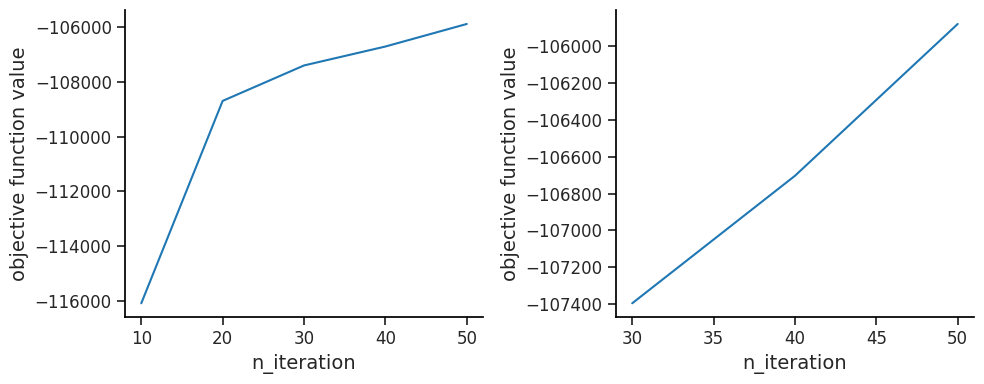

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# by default, the objective function value is computed every 10th iteration
multi_model.plot_history(ax=axes[0])

# the first iterations usually distory the history plot
multi_model.plot_history(min_iteration=30, ax=axes[1])

plt.tight_layout()

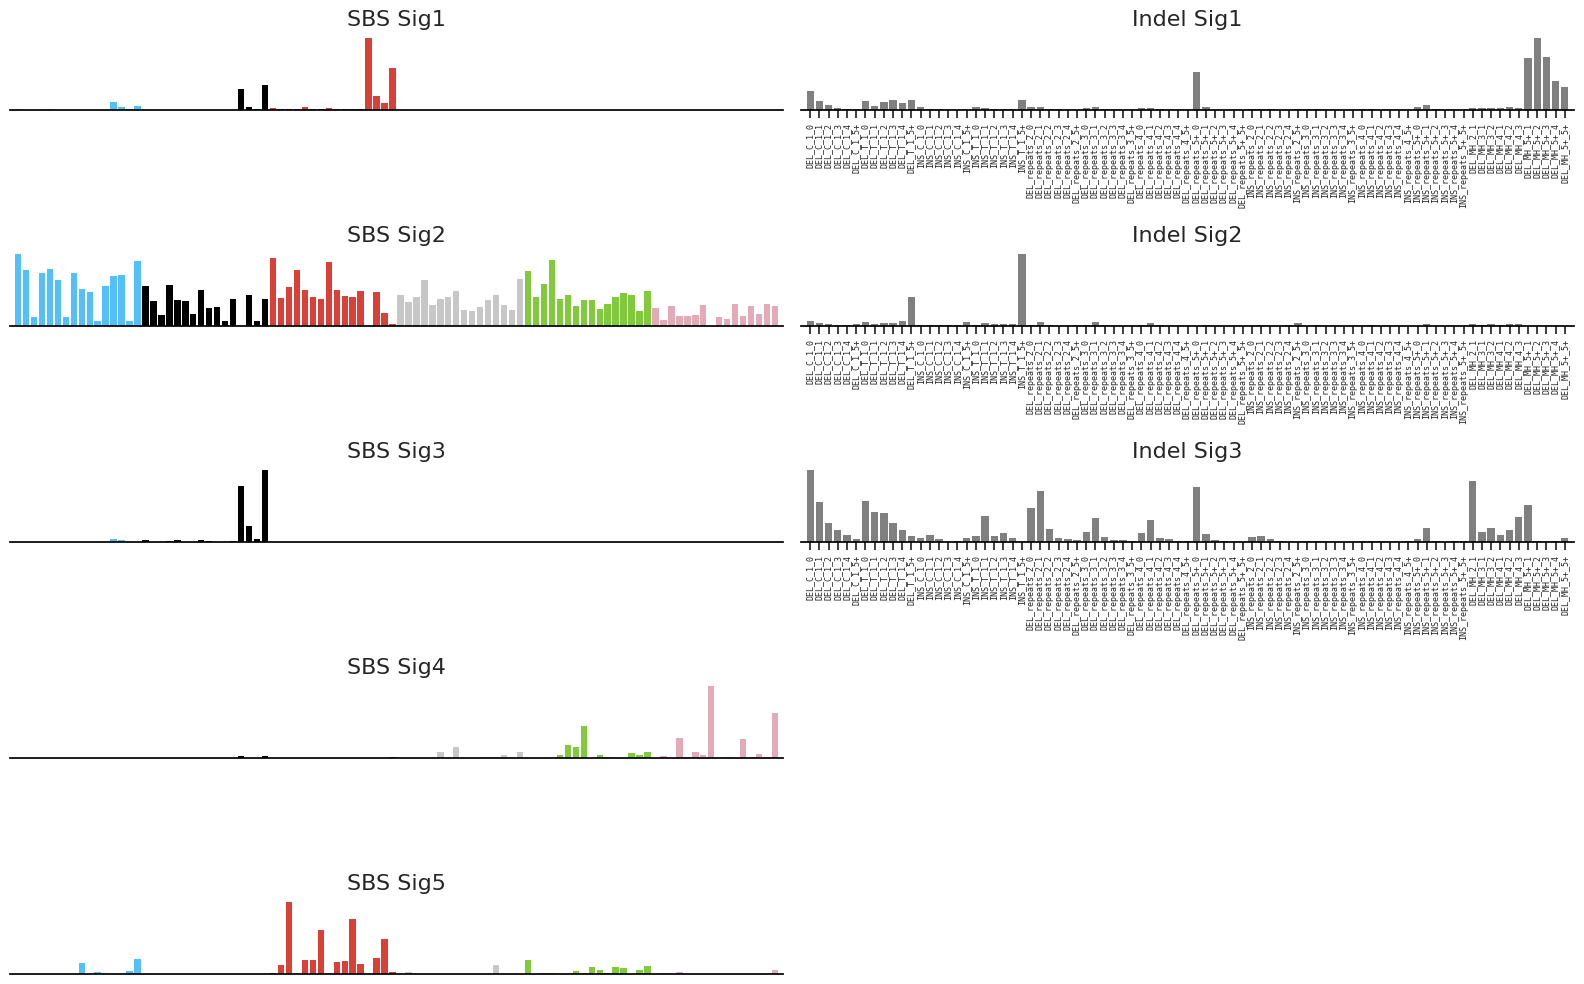

In [23]:
axes = multi_model.plot_signatures(annotate_mutation_types=True)

# remove mutation type annotations for the SBS signatures
for ax in axes[:,0]:
    ax.set_xticks([])

for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=6)

plt.tight_layout()

array([<Axes: title={'center': 'SBS signature exposures'}>,
       <Axes: title={'center': 'Indel signature exposures'}>],
      dtype=object)

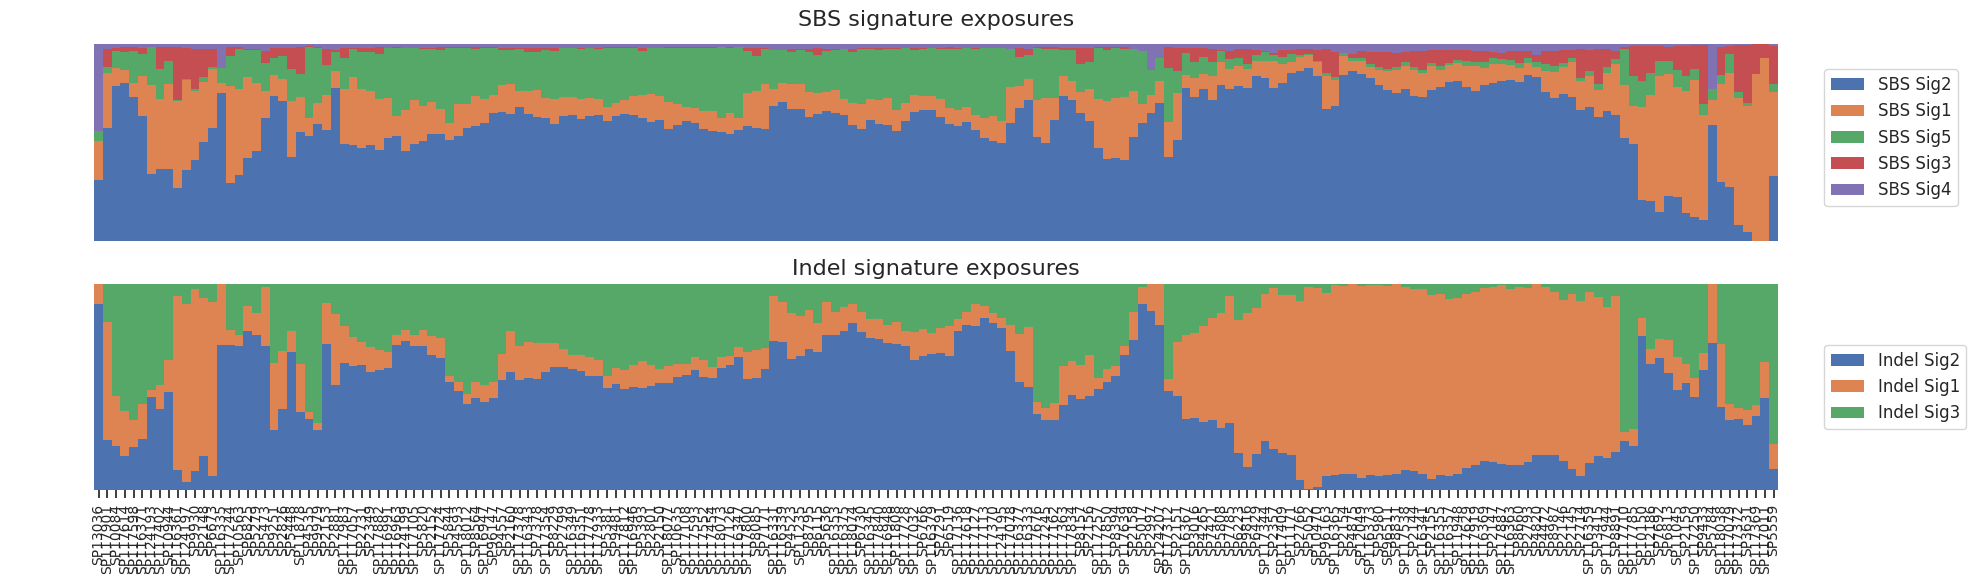

In [24]:
# exposures for each data modality
# samples are ordered jointly
multi_model.plot_exposures()

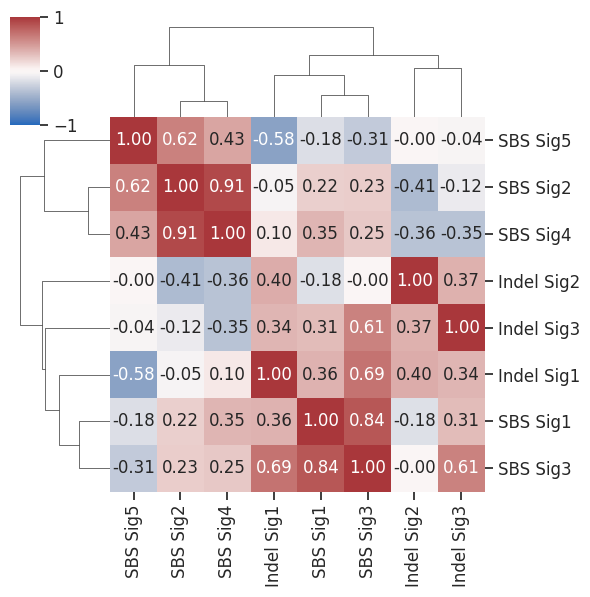

In [25]:
multi_model.plot_correlation(figsize=(6, 6), annot=True)

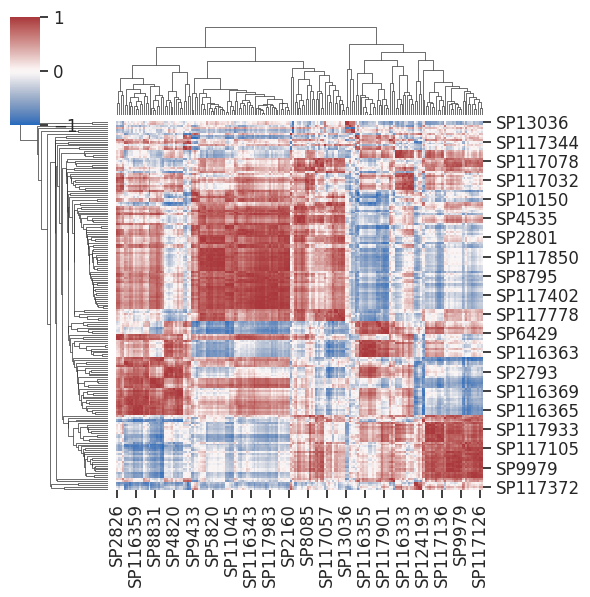

In [26]:
multi_model.plot_correlation(data="samples")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

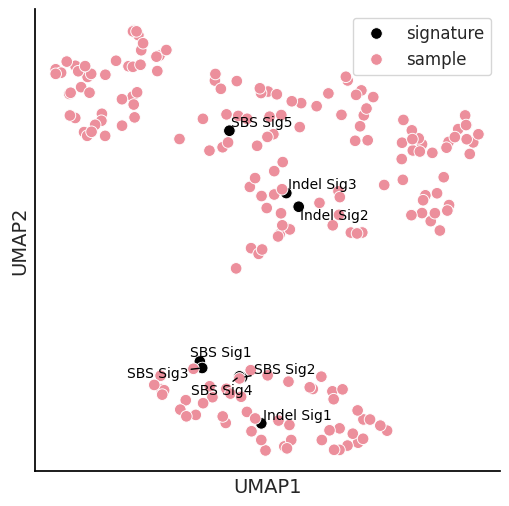

In [27]:
# the first data points of the projected data again correspond to the signatures
palette = [(0, 0, 0), "#ec8f9c"]
hue = np.sum(multi_model.ns_signatures) * ["signature"] + multi_model.n_samples * ["sample"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
multi_model.plot_embeddings(
    method="umap",
    hue=hue,
    palette=palette,
    s=70,
    annotation_kwargs={"fontsize": 10},
    adjust_kwargs={"arrowprops": dict(arrowstyle="-", color='k')},
    ax=ax
)

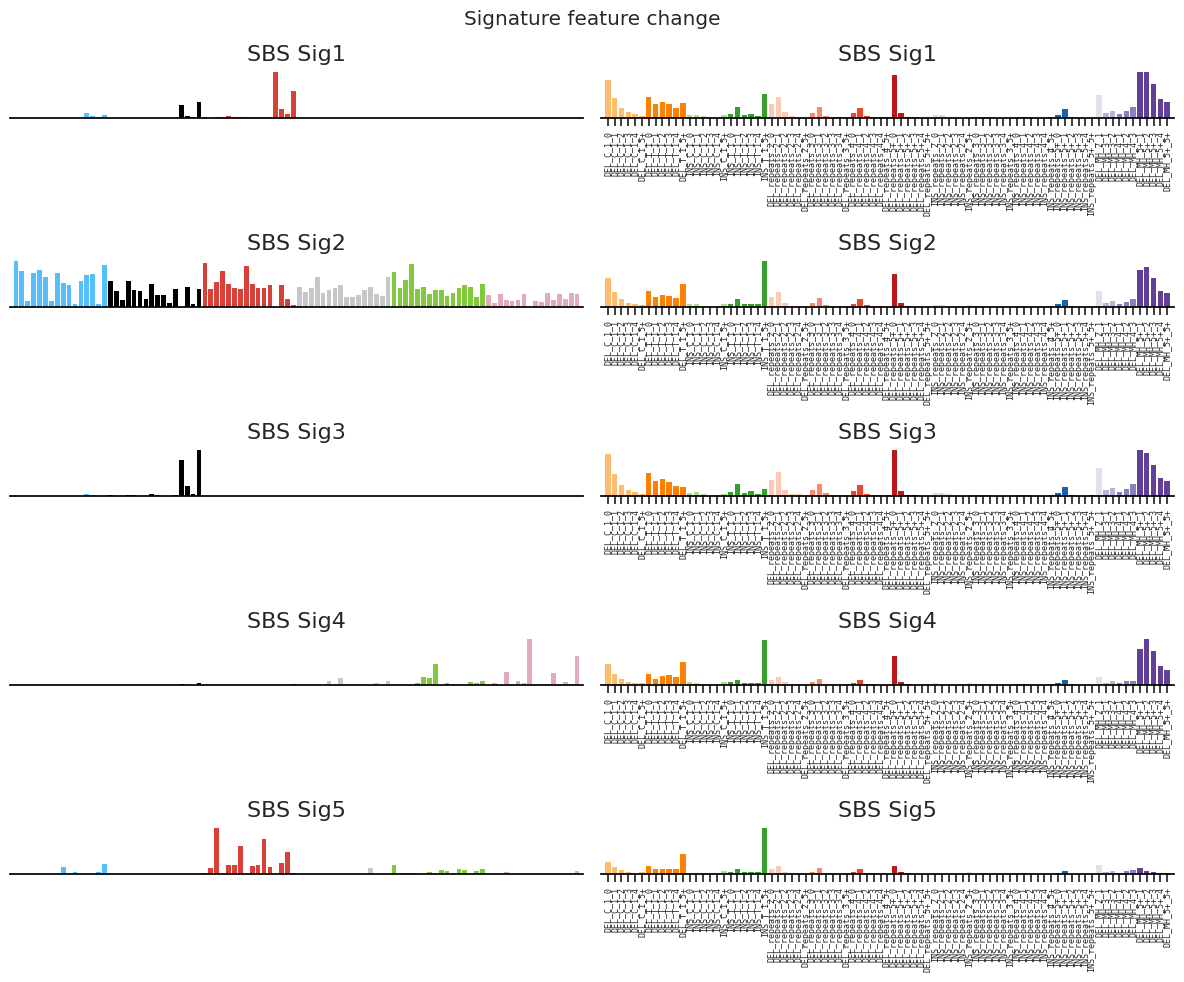

In [28]:
# co-occuring Indel spectra of all SBS signatures
axes = multi_model.plot_feature_change(
    in_modality="SBS",
    colors=["SBS96", "Indel83"],
    annotate_mutation_types=True,
    figsize=(12, 10)
)

for ax in axes[:,0]:
    ax.set_xticks([])

for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=6)

plt.tight_layout()